# 0. Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     Flatten,
                                     Dropout,
                                     BatchNormalization, 
                                     Conv2D, 
                                     MaxPooling2D)
from tensorflow.keras.regularizers import l2

# 1. Definition of the CNN architecture
Trained CNN weights loaded in the next part correspond to the CNN architecture presented below.

In [2]:
def create_model():
    """ Create sequential CNN with convolutional and dense layers
    
    """
    # number of ice classes
    nbr_classes = 4  
    # size of SAR subimages
    ws = 50
    # size of convolutional filters
    cs = 3
    # number of filters per convolutional layer (x id)
    c1,c2,c3 = 32,32,32
    # number of neurons per hidden neural layer number (x id)
    n1,n2,n3 = 16,16,64
    # value of dropout
    dropout_rate = 0.1
    # value of L2 regularisation
    l2_rate = 0.001

    model = Sequential()

    # Convolutional part
    model.add(BatchNormalization(input_shape=(ws, ws, 2)))
    model.add(Conv2D(c1, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(Conv2D(c2, (cs, cs), activation='relu'))
    model.add(Conv2D(c3, (cs, cs), activation='relu'))
    model.add(MaxPooling2D((2, 2),2))
    model.add(BatchNormalization())

    model.add(Flatten())

    # Neural network part (hidden layers)
    model.add(Dropout(dropout_rate))
    model.add(Dense(n1, kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n2,kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n3,kernel_regularizer=l2(l2_rate), activation='relu'))
    model.add(Dropout(dropout_rate))

    # Last neural layer (not hidden)
    model.add(Dense(nbr_classes,kernel_regularizer=l2(l2_rate), activation='softmax'))
    
    return model

# 2. CNN application
### 2.1. Import data

In [3]:
data = np.load('CNN_data.npz')
sigma0_HH = data['sigma0_HH']
sigma0_HV = data['sigma0_HV']

#### Sentinel-1 SAR image in HH polarization

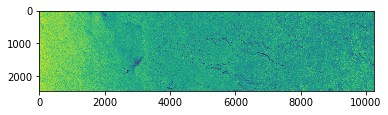

In [4]:
plt.imshow(sigma0_HH)

#### Sentinel-1 SAR image in HV polarization

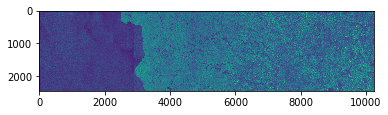

In [5]:
plt.imshow(sigma0_HV)

### 2.2. Convert 2D matrices into Nx50x50x2 array with SAR subimages

In [6]:
cnn_samples = []
# subimage size
size = 50

rows = range(0, sigma0_HH.shape[0] - size//2, size//2)
cols = range(0, sigma0_HH.shape[1] - size//2, size//2)
for row in rows:
    for col in cols:
        hh_sub = sigma0_HH[row:row+size, col:col+size]
        hv_sub = sigma0_HV[row:row+size, col:col+size]
        cnn_samples.append(np.stack([hh_sub, hv_sub], axis=2))

cnn_samples = np.array(cnn_samples)  
ice_chart_shape = (len(rows), len(cols))

### 2.3. Load model and trained weights

In [7]:
# creation of the model 
model = create_model()

# loading the trained weights
model.load_weights("weights.hdf5")

### 2.4. Apply CNN to SAR data

In [8]:
cnn_predictions = model.predict(cnn_samples).reshape((ice_chart_shape[0], ice_chart_shape[1], 4))

### 2.5. Build ice chart

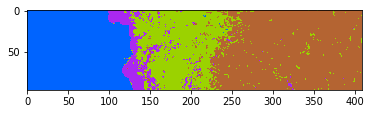

In [9]:
ice_class = np.argmax(cnn_predictions, axis=2)

color_scale = ['#0064FF', '#AA28F0', '#9BD200', '#B46432']
cmap = colors.ListedColormap(color_scale)  

plt.imshow(ice_class, cmap=cmap)

### 2.6. Build probability map

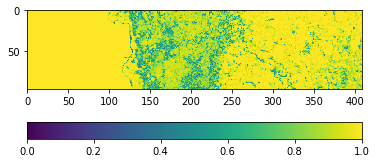

In [10]:
ice_proba = np.max(cnn_predictions, axis=2)

plt.imshow(ice_proba, clim=[0, 1])
plt.colorbar(orientation='horizontal')